In [255]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpol
from pyccl._core import UnlockInstance

# Ejected Gas & Bound Gas Profiles (separate profiles)

In [361]:
class ejGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the ejected gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, r_ej):
        self.r_ej = r_ej  
        super(ejGas_profile, self).__init__(mass_def=mass_def)

    def _real(self, r, M, r_ej, a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        rEj_use = np.atleast_1d(r_ej)

# Returns: float or array_like: halo profile. Shape of output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` and `M` respectively.
        prefix = M_use * (1/(a*np.sqrt(2*np.pi*rEj_use)))**3
        x = r_use[None, :] / rEj_use[:, None]
        prof = prefix[:, None] * np.exp(-(x**2)/2)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _fourier(self, k, M, r_ej, a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)
        rEj_use = np.atleast_1d(r_ej)

        prefix = M_use / a**3
        x = k_use[None, :] * rEj_use[:, None]
        prof = prefix[:, None] * np.exp(-(x**2)/2)  #prof = M_use * f * np.exp(-(1/2)*(k_use*r_ej)**2)/(a**3)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

In [587]:
class boundGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64): # n_q/Gamma = 2^x
        
        self.r_s = r_s 
        self.gamma = gamma
        super(boundGas_profile, self).__init__(mass_def=mass_def, concentration=concentration)

        self.GammaRange = GammaRange
        self.nGamma = nGamma

        self.qrange = qrange
        self.nq = nq
        
        self._func_normQ0 = None   # General normalised profile (for q=0, over Gamma)
        self._func_normQany = None

    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _innerInt(self, x, gam): 
        return x**2 * self._shape(x, gam)   

    import scipy.integrate as integrate
    import scipy.interpolate as interpol
    from pyccl._core import UnlockInstance

    def _Vb_prefix(self, r_s=1):
        vB1 = integrate.quad(self._innerInt, 0, np.inf, args = (1/(self.gamma-1)))  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(r_s**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 = for q = 0
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        I0_array = np.zeros(self.nGamma)
        k=0
        for i in gamma_list:
            I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
            k+=1
        func_normQ0 = interpol.interp1d(gamma_list, I0_array) # interp1d(x, y, ...
        return func_normQ0
        
    def _real(self, r, M, call_interp=True, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        
        R_M = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if call_interp==False:
            vB_prefix = self._Vb_prefix(r_s)
        else:
            if self._func_normQ0 is None: # is instead of == here
                with UnlockInstance(self):
                    self._func_normQ0 = self._norm_interpol1() 
            vB_prefix = 4*np.pi*(r_s**3)*self._func_normQ0(self.gamma)  # self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * (1/scale_a**3) * (1/vB_prefix)
# Returns: float or array_like: halo profile. Shape of the output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.

        x = r_use[None, :] / r_s[:, None]
        prof = prefix[:, None] * self._shape(x, 1/(self.gamma-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _norm_interpol2(self):  # interpol1 for q = any
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        q_array = np.geomspace(self.qrange[0], self.qrange[1], self.nq) # q = k*r_s, k will be from geomspace
        I0_array =  np.zeros((self.nGamma, self.nq))

        def integralQany(x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
            return x * self._shape(x, gam) # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]/q
        k=0
        for i in gamma_list: 
            l=0
            for j in q_array: 
                I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
                l+=1
            k+=1
            print(f'k = {100*k/self.nGamma:.3g}% through')
        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
        func_normQany = interpol.RegularGridInterpolator((gamma_list, np.log(q_array)), I0_array)
        return func_normQany
    
    def _fourier(self, k, M, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)

        R_M = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if self._func_normQ0 is None: # is instead of == here
            with UnlockInstance(self):
                self._func_normQ0 = self._norm_interpol1() 
        if self._func_normQany is None:
            with UnlockInstance(self):
                self._func_normQany = self._norm_interpol2()

        q_use = k_use[None, :]*r_s[:, None]
        g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0

        prefix = M_use / scale_a**3
        prof = prefix[:, None] * g_k[None,:] 

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

class boundGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, concentration, gamma, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64): # n_q/Gamma = 2^x
        
        self.gamma = gamma
        super(boundGas_profile, self).__init__(mass_def=mass_def, concentration=concentration)

        self.GammaRange = GammaRange
        self.nGamma = nGamma

        self.qrange = qrange
        self.nq = nq
        
        self._func_normQ0 = None   # General normalised profile (for q=0, over Gamma)
        self._func_normQany = None

    def _shape(self, x, gam):
        gam_use = np.atleast_1d(gam)
        return (np.log(1+x)/x)**gam_use

    def _innerInt(self, x, gam): 
        return x**2 * boundGas_profile._shape(x, gam)   

    import scipy.integrate as integrate
    import scipy.interpolate as interpol
    from pyccl._core import UnlockInstance

    def _Vb_prefix(self, r_s):
        vB1 = integrate.quad(boundGas_profile._innerInt, 0, np.inf, args = (1/(self.gamma-1)))  # (func, a, b[, args, full_output, ...])
        vB2 = 4*np.pi*(r_s**3)*vB1[0]
        return vB2

    def _norm_interpol1(self):  # interpol1 = for q = 0
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        I0_array = np.zeros(self.nGamma)
        k=0
        for i in gamma_list:
            I0_array[k] =  integrate.quad(boundGas_profile._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
            k+=1
        func_normQ0 = interpol.interp1d(gamma_list, I0_array) # interp1d(x, y, ...
        return func_normQ0
        
    def _real(self, r, M, call_interp=True, scale_a=1): 
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        
        R_M = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if call_interp==False:
            vB_prefix = self._Vb_prefix(r_s)
        else:
            if self._func_normQ0 is None: # is instead of == here
                with UnlockInstance(self):
                    self._func_normQ0 = boundGas_profile._norm_interpol1()#self) 
            vB_prefix = 4*np.pi*(r_s**3)*boundGas_profile._func_normQ0(self.gamma)  # self._Vb_prefix(gamma_use, rS_use)[0]
        prefix = M_use * (1/scale_a**3) * (1/vB_prefix)
# Returns: float or array_like: halo profile. Shape of the output = `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.

        x = r_use[None, :] / r_s[:, None]
        prof = prefix[:, None] * boundGas_profile._shape(x, 1/(self.gamma-1)) # default par of gam = 1/(gamma_use-1) #innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _norm_interpol2(self):  # interpol1 for q = any
        gamma_list = np.linspace(self.GammaRange[0], self.GammaRange[1], self.nGamma) # start, stop, number of evenly spaced samples
        q_array = np.geomspace(self.qrange[0], self.qrange[1], self.nq) # q = k*r_s, k will be from geomspace
        I0_array =  np.zeros((self.nGamma, self.nq))

        def integralQany(x, gam): #(a, gam=1/(gamma_use-1), b=1, c=1):
            return x * boundGas_profile._shape(x, gam) # for q = any (& j0(qx) = sinh(qx) = sin(qx)/(qx) => int[x^2 ... j0] = int[x ... sin(qx)]/q
        k=0
        for i in gamma_list: 
            l=0
            for j in q_array: 
                I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j
                l+=1
            k+=1
            print(f'k = {100*k/self.nGamma:.3g}% through')
        #interpol.RegularGridInterpolator() for 2D array # (points, values, ... 
        func_normQany = interpol.RegularGridInterpolator((gamma_list, np.log(q_array)), I0_array)
        return func_normQany
    
    def _fourier(self, k, M, scale_a=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)

        R_M = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a # halo virial radius
        c_M = self.concentration(cosmo, M_use, scale_a) # concentration-mass relation c(M)
        r_s = R_M / c_M # characteristic scale r_s

        if self._func_normQ0 is None: # is instead of == here
            with UnlockInstance(self):
                self._func_normQ0 = boundGas_profile._norm_interpol1() 
        if self._func_normQany is None:
            with UnlockInstance(self):
                self._func_normQany = boundGas_profile._norm_interpol2()

        q_use = k_use[None, :]*r_s[:, None]
        g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0

        prefix = M_use / scale_a**3
        prof = prefix[:, None] * g_k[None,:] 

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

# New Combined Class

Add in equations: $\rho(r)\ = f_b\ \rho_{bound}(r)\ + (1 - f_b)\rho_{ejected}(r)\ $

In [574]:
combinedGas_profile._fourier

<function __main__.combinedGas_profile._fourier(self, k, M, r_ej, f_bd=1, call_interp=True, scale_a=1)>

class combinedGas_profile(ccl.halos.profiles.profile_base.HaloProfile): 
    """Text
    """

    def __init__(self, mass_def, concentration, gamma, r_ej, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64):
        
        self.r_ej = r_ej  
        self.gamma = gamma
        # self.mass_def = mass_def self.concentration = concentration
        super().__init__(mass_def=mass_def, concentration=concentration)
        
       # super(combinedGas_profile, self).__init__(mass_def=mass_def, concentration=concentration)
      #  ejGas_profile.__init__(self, mass_def=mass_def, r_ej=r_ej)
        #boundGas_profile.__init__(self, mass_def=mass_def, concentration=concentration, gamma = gamma)
        # A.__init__(self, x=x, y=y)
        self.boundProfile = boundGas_profile(mass_def=mass_def, concentration=concentration, gamma=gamma)
        self.ejProfile = ejGas_profile

        self.GammaRange = GammaRange
        self.nGamma = nGamma
        self.qrange = qrange
        self.nq = nq
        self._func_normQ0 = None   # General normalised bound profile (for q=0, over Gamma)
        self._func_normQany = None

        import scipy.integrate as integrate
        import scipy.interpolate as interpol
        from pyccl._core import UnlockInstance

    def _real(self, r, M, r_ej, f_bd=1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = self.ejProfile._real(r, M, r_ej, scale_a)
        prof_bd = self.boundProfile._real(r, M, call_interp, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd
        return profile

    def _fourier(self, k, M, r_ej, f_bd = 1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = self.ejGas_profile._fourier(self, k, M, r_ej, scale_a)
        prof_bd = self.boundGas_profile._fourier(self, k, M, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd
        return profile

In [600]:
class combinedGas_profile(boundGas_profile, ejGas_profile): #ccl.halos.profiles.profile_base.HaloProfile): 
    """Text
    """

    def __init__(self, mass_def, concentration, gamma, r_ej, GammaRange = (1.01, 10), nGamma=64, qrange=(1e-4, 1e2), nq=64):
        
        self.r_ej = r_ej  
        self.gamma = gamma
        self.mass_def = mass_def 
        self.concentration = concentration
        #super().__init__(mass_def=mass_def, concentration=concentration)
       # self.boundProfile = boundGas_profile(mass_def=mass_def, concentration=concentration, gamma=gamma)
       # self.ejProfile = ejGas_profile

        self.GammaRange = GammaRange
        self.nGamma = nGamma
        self.qrange = qrange
        self.nq = nq
        self._func_normQ0 = None   # General normalised bound profile (for q=0, over Gamma)
        self._func_normQany = None

        import scipy.integrate as integrate
        import scipy.interpolate as interpol
        from pyccl._core import UnlockInstance

    def _real(self, r, M, r_ej, f_bd=1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = ejGas_profile._real(self, r, M, r_ej, scale_a)
        prof_bd = boundGas_profile._real(self, r, M, call_interp, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd
        return profile

    def _fourier(self, k, M, r_ej, f_bd = 1, call_interp=True, scale_a=1):
        f_ej = 1 - f_bd
        prof_ej = ejGas_profile._fourier(self, k, M, r_ej, scale_a)
        prof_bd = boundGas_profile._fourier(self, k, M, scale_a)
        profile = f_ej*prof_ej + f_bd*prof_bd
        return profile

# Trial

In [604]:
hmd_200c = ccl.halos.MassDef200c # use a mass definition with Delta = 200
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200c)
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.07, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
trial_gamma = 1.1  # working with z = 0 (today) ; therefore a = 1 [default]
trial_rEj = 100
trial_rS = 1       

In [606]:
trial_profile = combinedGas_profile(hmd_200c, cM, trial_gamma, trial_rEj)

## Real

In [609]:
trial_f_bd = 0.7
profTrial_real = trial_profile._real(trial_r, trial_M, trial_rEj, trial_f_bd) 
# _real(self, r, M, r_ej, f_bd=1, call_interp=True, scale_a=1)
profTrial_real

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:41: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:41: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I0_array[k] =  integrate.quad(self._innerInt, 0, np.inf, args = 1/(i-1))[0] # _innerInt(self, x, gam=1/(gamma_use-1))


array([[5.42579817e+13, 5.42555413e+13, 5.42531004e+13, ...,
        5.39172055e-60, 5.37994492e-60, 5.36819501e-60],
       [4.17136818e+13, 4.17126146e+13, 4.17115471e+13, ...,
        9.20280116e-58, 9.18273415e-58, 9.16271089e-58],
       [2.93677687e+13, 2.93673814e+13, 2.93669940e+13, ...,
        3.55197247e-55, 3.54424263e-55, 3.53652960e-55]])

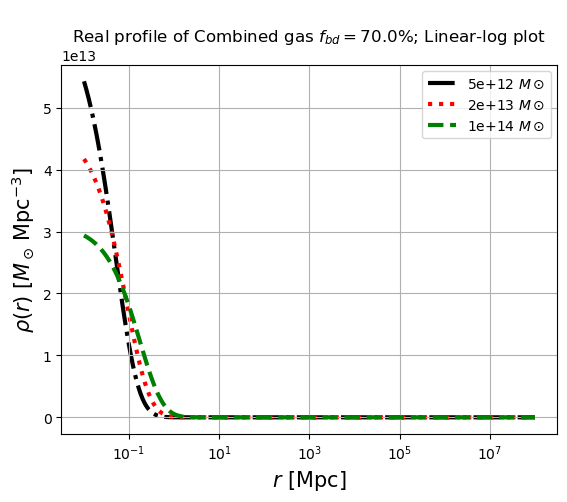

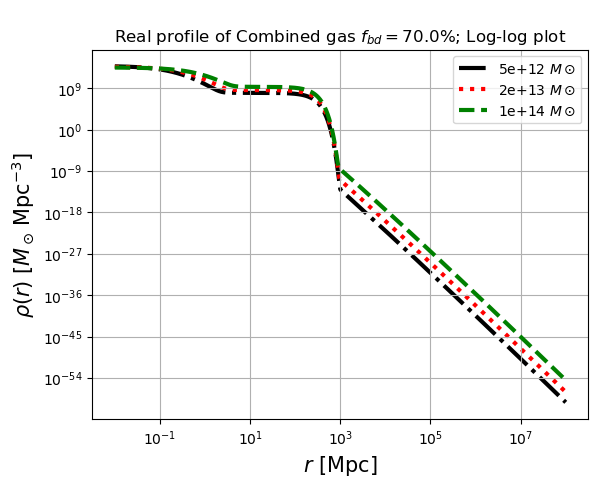

In [611]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_real = '\nReal profile of Combined gas $f_{bd}=$'+f'{trial_f_bd*100}%;' 
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_real[i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title(title_real+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');  

## Fourier

In [355]:
(trial_k[None, :])

array([[1.00000000e-04, 1.00013817e-04, 1.00027635e-04, ...,
        9.99723725e+01, 9.99861853e+01, 1.00000000e+02]])

In [613]:
trial_k = np.geomspace(1E-3,1E2,100000)
profTrial_fourier = trial_profile._fourier(trial_k, trial_M, trial_rEj, trial_f_bd)
profTrial_fourier  #_fourier(self, k, M, r_ej, f_bd = 1, call_interp=True, scale_a=1)

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return (np.log(1+x)/x)**gam_use
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:85: IntegrationWarning: The maximum number of cycles allowed has been achieved., e.e.
  of subintervals (a+(k-1)c, a+kc) where c = (2*int(abs(omega)+1))
  *pi/abs(omega), for k = 1, 2, ..., lst.  One can allow more cycles by increasing the value of limlst.  Look at info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 1.56% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:85: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 3.12% through
k = 4.69% through
k = 6.25% through
k = 7.81% through
k = 9.38% through
k = 10.9% through
k = 12.5% through
k = 14.1% through
k = 15.6% through
k = 17.2% through
k = 18.8% through
k = 20.3% through
k = 21.9% through
k = 23.4% through
k = 25% through
k = 26.6% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:85: IntegrationWarning: The extrapolation table constructed for convergence acceleration
  of the series formed by the integral contributions over the cycles, 
  does not converge to within the requested accuracy.  Look at 
  info['ierlst'] with full_output=1.
  I0_array[k, l] =  integrate.quad(integralQany, 0, np.inf, args = 1/(i-1), weight = "sin", wvar=j)[0] / j


k = 28.1% through
k = 29.7% through
k = 31.2% through
k = 32.8% through
k = 34.4% through
k = 35.9% through
k = 37.5% through
k = 39.1% through
k = 40.6% through
k = 42.2% through
k = 43.8% through
k = 45.3% through
k = 46.9% through
k = 48.4% through
k = 50% through
k = 51.6% through
k = 53.1% through
k = 54.7% through
k = 56.2% through
k = 57.8% through
k = 59.4% through
k = 60.9% through
k = 62.5% through
k = 64.1% through
k = 65.6% through
k = 67.2% through
k = 68.8% through
k = 70.3% through
k = 71.9% through
k = 73.4% through
k = 75% through
k = 76.6% through
k = 78.1% through
k = 79.7% through
k = 81.2% through
k = 82.8% through
k = 84.4% through
k = 85.9% through
k = 87.5% through
k = 89.1% through
k = 90.6% through
k = 92.2% through
k = 93.8% through
k = 95.3% through
k = 96.9% through
k = 98.4% through
k = 100% through


/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:109: RuntimeWarning: overflow encountered in divide
  g_k = self._func_normQany((self.gamma, np.log(q_use))) / self._func_normQ0(self.gamma) # = Ib_qAny / Ib_q0
/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5363/3446510733.py:112: RuntimeWarning: overflow encountered in multiply
  prof = prefix[:, None] * g_k[None,:]


array([[[4.99242950e+12, 4.99242778e+12, 4.99242606e+12, ...,
                    inf,            inf,            inf],
        [1.99696613e+13, 1.99696544e+13, 1.99696475e+13, ...,
                    inf,            inf,            inf],
        [9.98471692e+13, 9.98471345e+13, 9.98470998e+13, ...,
                    inf,            inf,            inf]]])

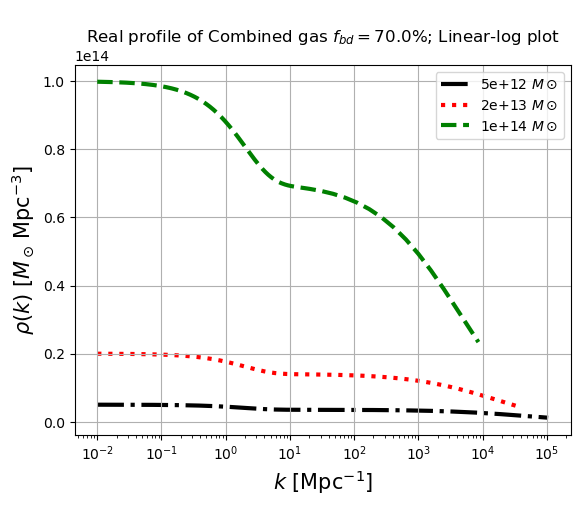

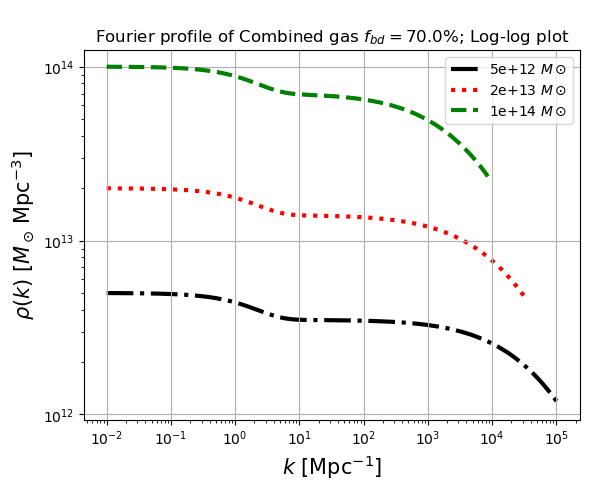

In [618]:
colours, i = ['k-.', 'r:', 'g--'], 0
title_fourier = '\nFourier profile of Combined gas $f_{bd}=$'+f'{trial_f_bd*100}%;' 
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_fourier[0,i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_real+' Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');   #plt.xlim(1e-2,1e5);   #plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j, col in zip(trial_M, colours):
    plt.plot(trial_r, profTrial_fourier[0,i], col, lw=3, zorder = i, label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title(title_fourier+' Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log'); 

# delete

In [172]:
print(combinedGas_profile.mro())

[<class '__main__.combinedGas_profile'>, <class '__main__.boundGas_profile'>, <class '__main__.ejGas_profile'>, <class 'pyccl.halos.profiles.profile_base.HaloProfile'>, <class 'pyccl._core.schema.CCLAutoRepr'>, <class 'pyccl._core.schema.CCLObject'>, <class 'abc.ABC'>, <class 'object'>]


In [72]:
boundGas_profile.__init__

<function __main__.boundGas_profile.__init__(self, mass_def, gamma, concentration, r_s=1, GammaRange=(1.01, 10), nGamma=64, qrange=(0.0001, 100.0), nq=64)>

In [152]:
ejGas_profile.__init__

<function __main__.ejGas_profile.__init__(self, mass_def, r_ej)>